In [ ]:
# 📦 Imports for training & saving embeddings
import os
import cv2
import numpy as np
import pickle
from insightface.app import FaceAnalysis

# 🚀 Initialize InsightFace model
model = FaceAnalysis(name='buffalo_l')
model.prepare(ctx_id=-1)  # Use -1 for CPU

# 📁 Directory with labeled training images
training_path = 'Training_images'
known_embeddings = []
classNames = []

# 📌 Process each image
for file in os.listdir(training_path):
    img_path = os.path.join(training_path, file)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    faces = model.get(img_rgb)
    if faces:
        emb = faces[0].embedding
        known_embeddings.append(emb)
        name = os.path.splitext(file)[0]
        classNames.append(name)
    else:
        print(f"⚠️ No face detected in {file}")

# 💾 Save embeddings + names
data = {
    'embeddings': np.array(known_embeddings),
    'names': classNames
}
with open('face_data.pkl', 'wb') as f:
    pickle.dump(data, f)

print("✅ Saved face embeddings to face_data.pkl")


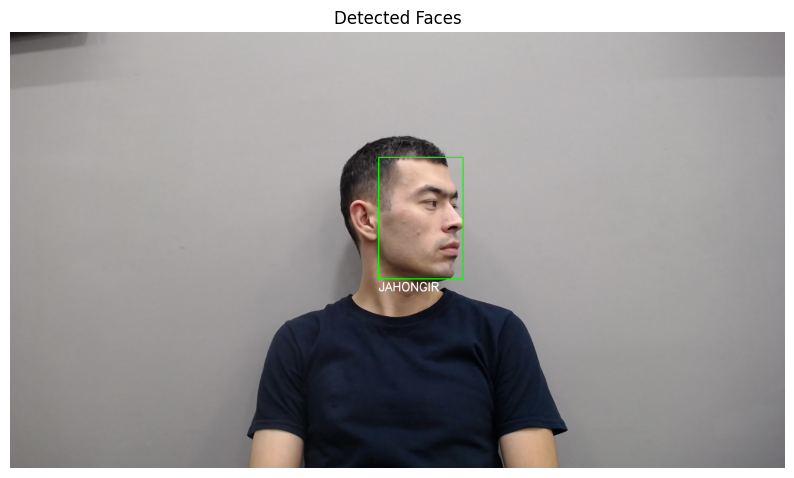

In [13]:
# 📦 Imports for recognition
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
from insightface.app import FaceAnalysis
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import clear_output

# 📥 Load saved embeddings
with open('face_data.pkl', 'rb') as f:
    data = pickle.load(f)
known_embeddings = data['embeddings']
classNames = data['names']

# 🚀 Initialize model again (needed in separate cell)
model = FaceAnalysis(name='buffalo_l')
model.prepare(ctx_id=-1)

# 📸 Load a test image
test_image_path = 'test3.jpg'  # Change as needed
test_img = cv2.imread(test_image_path)
test_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# 🤖 Detect & recognize faces
faces = model.get(test_rgb)

for face in faces:
    emb = face.embedding.reshape(1, -1)
    sims = cosine_similarity(emb, known_embeddings)[0]
    
    max_sim = np.max(sims)
    best_idx = np.argmax(sims)
    name = classNames[best_idx].upper() if max_sim > 0.5 else "UNKNOWN"

    # 🎯 Draw bounding box and label
    x1, y1, x2, y2 = face.bbox.astype(int)
    cv2.rectangle(test_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(test_img, name, (x1, y2 + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

# 📷 Display result
clear_output(wait=True)
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Detected Faces")
plt.show()
